<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/custom_entity_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [4]:
!pip install spacymoji
from spacymoji import Emoji

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=73552e66585d1e89e79d016357368b03dcdf542dd0781ca1fa8b4315a750714a
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import random
import srsly
import json
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.util import minibatch, compounding
from pandas.io.json import json_normalize
from spacy.gold import docs_to_json, biluo_tags_from_offsets, offsets_from_biluo_tags
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

import itertools

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
def cleanse_text(text):
  step1 = re.sub(r"(\{'LOWER':\s)",r"",str(text))
  step2 = re.sub(r"[\[{\'\,\"}\]]",r"",step1)
  return step2

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']

        print(text, annotations)
        valid_entities = []
        for start, end, label in entities:
          valid_start = start
          valid_end = end
          print(valid_start, valid_end, len(text))
          while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
            valid_start += 1
          while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
            valid_end -= 1
          valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data


def create_entity_pattern(ent_name, ent_label):
  pattern_list = []
  pattern_dict = {}
  id_str = ''
  for word in ent_name.lower().split():
    token_dict = {}
    token_dict['LOWER'] = word
    pattern_list.append(token_dict)
    id_str += '_' + word
  if ent_label[:2] == 'U_':
    pattern_dict['label'] = ent_label[2:]
  else:
    pattern_dict['label'] = ent_label  
  pattern_dict['pattern'] = pattern_list
  if id_str[0] == '_':
    id_str = id_str[1:]
  pattern_dict['id'] = id_str
  return pattern_dict

In [8]:
ls -l p*

-rw------- 1 root root  18045 Dec 26 16:46 pastries_list.jsonl
-rw------- 1 root root   1544 Dec 26 18:06 pastry_keyword_patterns.npz
-rw------- 1 root root   2365 Dec 26 18:11 pattern_bread.jsonl
-rw------- 1 root root   4609 Dec 26 18:11 pattern_condiment.jsonl
-rw------- 1 root root   5397 Dec 26 18:11 pattern_fruit.jsonl
-rw------- 1 root root   3946 Dec 26 18:11 pattern_herb.jsonl
-rw------- 1 root root   1700 Dec 26 18:11 pattern_pastry.jsonl
-rw------- 1 root root 529064 Dec 26 14:49 patterns_2019_12_26.jsonl
-rw------- 1 root root 589611 Jan  8 14:35 patterns_2020_01_08.jsonl
-rw------- 1 root root 590005 Jan  8 14:36 patterns.jsonl
-rw------- 1 root root   6749 Dec 26 18:11 pattern_spice.jsonl
-rw------- 1 root root   9140 Dec 26 18:11 pattern_vegetable.jsonl
-rw------- 1 root root 130017 Dec 14 15:06 pyLDAvis_10.html
-rw------- 1 root root 144690 Dec 14 15:10 pyLDAvis_11.html
-rw------- 1 root root 291844 Dec 14 16:48 pyLDAvis_12.html
-rw------- 1 root root 168973 Dec 14 15:1

In [9]:
df_pattern = pd.read_json('patterns.jsonl',lines=True)
df_pattern['cleaned_pattern'] = df_pattern.pattern.apply(lambda x: cleanse_text(x))
df_pattern['label'] = 'U_' + df_pattern.label.astype(str)
df_pattern['tup_col'] = list(zip(df_pattern.cleaned_pattern, df_pattern.label))
df_pattern['merged'] = df_pattern.apply(lambda row: {row['cleaned_pattern']:row['label']}, axis=1)
df_pattern.head()
df_pattern.tail()

,label,pattern,id,cleaned_pattern,tup_col,merged
6724,U_ORG,"[{'LOWER': 'hard'}, {'LOWER': 'rock'}, {'LOWER...",hard_rock_cafe,hard rock cafe,"(hard rock cafe, U_ORG)",{'hard rock cafe': 'U_ORG'}
6725,U_meal,[{'LOWER': 'entree'}],entree,entree,"(entree, U_meal)",{'entree': 'U_meal'}
6726,U_meal,"[{'LOWER': 'side'}, {'LOWER': 'dish'}]",side_dish,side dish,"(side dish, U_meal)",{'side dish': 'U_meal'}
6727,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'zucchini'}]",yellow_zucchini,yellow zucchini,"(yellow zucchini, U_vegetable)",{'yellow zucchini': 'U_vegetable'}
6728,U_vegetable,"[{'LOWER': 'green'}, {'LOWER': 'zucchini'}]",green_zucchini,green zucchini,"(green zucchini, U_vegetable)",{'green zucchini': 'U_vegetable'}


In [10]:
ent_list = df_pattern.tup_col.to_list()
ent_list[-10:]

[('duddell s', 'U_ORG'),
 ('hong kong', 'U_GPE'),
 ('dumpling', 'U_dish'),
 ('red chilies', 'U_spice'),
 ('pollo frito', 'U_dish'),
 ('hard rock cafe', 'U_ORG'),
 ('entree', 'U_meal'),
 ('side dish', 'U_meal'),
 ('yellow zucchini', 'U_vegetable'),
 ('green zucchini', 'U_vegetable')]

In [0]:
nlp = spacy.load("en_core_web_lg")
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')

In [12]:
nlp.pipe_names

['emoji', 'tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

In [263]:
ruler.patterns[-3:]

[{'id': 'seaweed_chips',
  'label': 'dish',
  'pattern': [{'LOWER': 'seaweed'}, {'LOWER': 'chips'}]},
 {'id': 'gula_melaka',
  'label': 'condiment',
  'pattern': [{'LOWER': 'gula'}, {'LOWER': 'melaka'}]},
 {'id': 'waffles', 'label': 'dish', 'pattern': [{'LOWER': 'waffles'}]}]

In [13]:
doc1 = nlp("I love fettuccine cheese 💚🌿 but hate buffalo wings while preferring a Lebanese diet.")
print([(ent.text, ent.label_, ent.ent_id_) for ent in doc1.ents])

displacy.render(doc1,'ent',jupyter=True)



[('fettuccine', 'dish', 'fettuccine'), ('buffalo wings', 'dish', 'buffalo_wings'), ('Lebanese', 'NORP', 'lebanese')]


In [14]:
doc2 = nlp("Avocado 🌿 is good but Indian cuising such as chicken tikka masala and paneer tikka masala are fantastic while sweet potato fries is atrocious in Egypt and India")
displacy.render(doc2,'ent',jupyter=True)

In [15]:
doc3 = nlp("Firstly, baguette is the best bread in the whole world - bagels come close and for ten dollars ciabatta is available")
displacy.render(doc3,'ent',jupyter=True)

In [16]:
doc4 = nlp("Peanut butter ice cream is good but chocolate ice cream is better.")
displacy.render(doc4,'ent',jupyter=True)

In [18]:
doc5 = nlp("basil is a great herb and the first ice cream I tasted was good but mushroom stem at $ 5 is yet to be seen.")
displacy.render(doc5,'ent',jupyter=True)

In [19]:
reviews = pd.read_csv('reviews_text.csv',usecols=['_id', 'text'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56156 entries, 0 to 56155
Data columns (total 2 columns):
_id     56156 non-null object
text    56155 non-null object
dtypes: object(2)
memory usage: 877.6+ KB


In [20]:
reviews.dropna(inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56155 entries, 0 to 56155
Data columns (total 2 columns):
_id     56155 non-null object
text    56155 non-null object
dtypes: object(2)
memory usage: 1.3+ MB


In [21]:
train_reviews = reviews['text'][100:2000]
train_reviews

100     I keep going back again and again for the awes...
101     Nothing keeps me fueled like all the amazing p...
102     What a great find for a healthy lunch! I reall...
103     This is honestly one of the best things I've e...
104     Love my colourful bowl - phytonutrients yayyy!...
                              ...                        
1995    Part of an all-you-can-eat vegan lunch set. Al...
1996    Part of an all-you-can-eat vegan lunch set. Th...
1997    Egg white omelette with asparagus, feta, sauté...
1998    This dish of stuffed tomatoes and green pepper...
1999    Yummy warm dessert with crumbled hazelnuts and...
Name: text, Length: 1900, dtype: object

In [0]:
ingredients_list = ['pistachio', 'almond', 'walnut', 'cashew', 'peanuts', 'macadamia', 'hazelnuts', 'pecan', 'brazil nut', 'pine nut' ]
issues_list = ['crumble - maybe a verb', 'milk']
food_times = 
to_be_added_list = ['spirulina', 'herbs', 'micro-greens', 'greens','spinach','eggs', 'nut butters', 'cream cheese', 'cake', 'pepper', 'zucchini', 'aubergines',  'tomato',\
                    'oysters', 'kale', 'cucumber', 'quinoa', 'tomatoes', 'onion' ,'garlic', 'avocado', 'chilli', 'dark chocolate', 'mushrooms', 'coriander' ,'corn chips',\
                    'marinara', 'donuts', 'olives', 'crackers', 'waffles', 'strawberry', 'blueberry', 'raspberry', 'compote', 'mayo', 'mayonnaise', 'soy milk', 'oat milk', \
                    'coconut milk', 'almond milk', 'caffeine', 'milk tea', 'cauliflower', 'matcha', 'sorbet', 'banana', 'goji berry', 'chickpea', 'spinach', 'romaine',\
                    'arugula', 'cacao', 'Portobello', 'pear', 'plant milk', 'BBQ sauce', 'artichoke', 'mango', 'sandwich', 'capsicum', 'wedge', 'kang kong', 'seitan',\
                    'ciabatta', 'focaccia', 'bean sprouts', 'olive oil']

In [0]:
check = np.random.randint(0,50000,3)
print(check)

for doc in list(nlp.pipe(texts[check])):
  displacy.render(doc,'ent',jupyter=True)
#  displacy.render(doc,'dep',jupyter=True,options={'distance': 60, 'fine_grained': True})



[49671 32259 46827]


In [0]:
f = open('rice.txt')
docs = [] # initialize a list to be populated wih strings
lines = f.readlines()  # returns a list of srings from the txt file
for line in lines:
    # print(line[:]) # display the sentence from that line
    doc = nlp(line) # convert string into a spacy doc object using nlp
    docs.append(doc) # add new doc to the list of docs

json_data = docs_to_json(docs) # convert doc into a json file
srsly.write_json('spacy_train.json', [json_data])


In [0]:
f.close()

In [0]:
check_list = [('bok','U_vegetable'),('choy','U_vegetable'),\
              ('bean','U_vegetable'), ('sprouts','U_vegetable'),\
              ('soffritto','U_dish'),('patties','U_dish'),('cakes','U_dish'),('parmesan','U_dish'),('cheese','U_dish'),('breadcrumbs','U_dish'),\
              ('soy','U_condiment'),('sauce','U_condiment'),\
              ('olive','U_condiment'),('oil','U_condiment'),\
              ('wine','U_beverage'),\
              ('3/4-inch','U_QUANTITY'), ('2-inch','U_QUANTITY'),('3-inch','U_QUANTITY'),('6-inch','U_QUANTITY'),\
              ('first','U_ORDINAL'),('second','U_ORDINAL'),('third','U_ORDINAL'),('fourth','U_ORDINAL'),('fifth','U_ORDINAL'),('last','U_ORDINAL'),\
              ('1','U_CARDINAL'),('2','U_CARDINAL'),('3','U_CARDINAL'),('4','U_CARDINAL'),('5','U_CARDINAL'),('6','U_CARDINAL'),('10','U_CARDINAL'),\
              ('100','U_CARDINAL'),('one','U_CARDINAL'),('two','U_CARDINAL'),('three','U_CARDINAL'),('four','U_CARDINAL'),('five','U_CARDINAL'),('six','U_CARDINAL'),\
              ('seven','U_CARDINAL'),('eight','U_CARDINAL'),('nine','U_CARDINAL'),('ten','U_CARDINAL'),\
              ('minute','U_TIME'),('minutes','U_TIME'),('seconds','U_TIME'),('hour','U_TIME'),('hours','U_TIME'),('day','U_TIME'),\
              ('$', 'U_MONEY'), ('USD', 'U_MONEY'),('SGD', 'U_MONEY'),('S$', 'U_MONEY'), ('Rs', 'U_MONEY'), ('£', 'U_MONEY'), ('€', 'U_MONEY')]

In [0]:
f = open('rice.txt')
docs = [] # initialize a list to be populated wih strings
lines = f.readlines()  # returns a list of srings from the txt file
for line in lines:
    # print(line[:]) # display the sentence from that line
    doc = nlp(line) # convert string into a spacy doc object using nlp
    docs.append(doc) # add new doc to the list of docs
f.close()



In [0]:
train_gen = (line for line in open('rice.txt'))
type(train_gen)
to_train_ents = []

In [56]:
l = next(train_gen)
tok_list = [token.text for token in nlp(l)] 
#print(l, tok_list)
tag_list = ['O' for token in nlp(l)]
#print(tag_list)
matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]] 
#print(matched_ents)

for ent in matched_ents:
  ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
  print(ent[0], ent[1], ent_tag)
  tag_list[ent[0]] = ent_tag

#print(tag_list)
entities = offsets_from_biluo_tags(nlp(l), tag_list)
print(entities)
to_train_ents.append((l, dict(entities = entities)))
displacy.render(nlp(l),'ent',jupyter=True)
print(l, entities)

#displacy.render(l,'dep',jupyter=True)

[]


Leave alone for five to seven minutes, then serve. []


In [57]:
len(to_train_ents)
#to_train_ents[-5:]

37

In [58]:
to_train_ents[0:5]

[('If using tofu, cook it.\n', {'entities': [(9, 13, 'dish')]}),
 ('Cook the rice as you normally would, but be careful not to use too much water. The rice should not be too sticky. It may help to let the cooked rice sit overnight in the refrigerator.\n',
  {'entities': [(9, 13, 'dish'), (83, 87, 'dish'), (137, 148, 'dish')]}),
 ('If using onions, dice them into whatever size you prefer.\n',
  {'entities': [(9, 15, 'vegetable')]}),
 ('If using bok choy, separate the stalk part from the leaf part. Slice the leaf part crosswise into 3/4-inch-thick strips, then tear the strips into 2-inch pieces. These pieces will be treated much like the bean sprouts, though perhaps with slightly more cooking. The stalk part will be treated as celery.\n',
  {'entities': [(9, 17, 'vegetable'),
    (98, 106, 'QUANTITY'),
    (147, 153, 'QUANTITY'),
    (205, 217, 'vegetable'),
    (296, 302, 'vegetable')]}),
 ('If using bean sprouts, wash them and discard any that are not white and crunchy.\n',
  {'entitie

In [0]:

merged = list(itertools.chain(*[tup[1]['entities'] for tup in to_train_ents]))

In [61]:
model = 'en_core_web_lg'



"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in to_train_ents:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [62]:
ner.labels

('dish',
 'ORG',
 'condiment',
 'FAC',
 'vegetable',
 'ORDINAL',
 'PERSON',
 'PRODUCT',
 'LOC',
 'spice',
 'CARDINAL',
 'LANGUAGE',
 'TIME',
 'WORK_OF_ART',
 'GPE',
 'DATE',
 'LAW',
 'NORP',
 'beverage',
 'MONEY',
 'EVENT',
 'herb',
 'PERCENT',
 'QUANTITY')

In [0]:
from spacy.gold import GoldParse

In [66]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(5):
      random.shuffle(clean_train_ents)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(clean_train_ents, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=0.5, losses=losses)
        print(losses)

{'ner': 68.43624067306519}
{'ner': 184.61740112304688}
{'ner': 258.61230278015137}
{'ner': 335.3837299346924}
{'ner': 397.74806785583496}
{'ner': 496.07928681373596}
{'ner': 604.3904078006744}
{'ner': 697.9849517345428}
{'ner': 898.3083918094635}
{'ner': 913.0961752086878}
{'ner': 77.2951397895813}
{'ner': 199.11220693588257}
{'ner': 272.8479437828064}
{'ner': 399.1770589351654}
{'ner': 510.91890597343445}
{'ner': 571.7339107990265}
{'ner': 673.7506942749023}
{'ner': 836.8600540161133}
{'ner': 893.0359942913055}
{'ner': 904.4475624634651}
{'ner': 76.6790599822998}
{'ner': 248.98345279693604}
{'ner': 359.4646096229553}
{'ner': 447.50255060195923}
{'ner': 550.7681419849396}
{'ner': 665.9656307697296}
{'ner': 718.2194759845734}
{'ner': 780.4857132434845}
{'ner': 906.0226509571075}
{'ner': 942.5896518924274}
{'ner': 68.84220838546753}
{'ner': 148.96541571617126}
{'ner': 251.8399977684021}
{'ner': 350.8443260192871}
{'ner': 446.8515214920044}
{'ner': 509.65203619003296}
{'ner': 614.89673566

In [0]:
check_list = []
to_train_ents = []

In [23]:
train_rev = (rev for rev in train_reviews)
type(train_rev)

generator

In [139]:
rev = next(train_rev)
tok_list = [token.text for token in nlp(rev)] 
tag_list = ['O' for token in nlp(rev)]
matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]] 
#print(rev, tok_list, tag_list, matched_ents)

ent_for_doc = []
pattern_dict = {}
for ent in matched_ents:
  ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
  ent_for_doc.append((ent[0], ent[1], ent_tag))  
  tag_list[ent[0]] = ent_tag
print(ent_for_doc)
#print(tag_list)
entities = offsets_from_biluo_tags(nlp(rev), tag_list)
print(entities)
to_train_ents.append((rev, dict(entities = entities)))
displacy.render(nlp(rev),'ent',jupyter=True)


n_entities_to_be_added = int(input("How many entities are missing: "))
if n_entities_to_be_added == 0:
  print('You entered {} Thanks. So no new entities to be considered'.format(n_entities_to_be_added))
else:
  for user_input in range(n_entities_to_be_added):
    e_name = input('Provide the name of the entity to be added: ')
    e_label = input('Provide the label of the entity to be added:')
    print(e_name, e_label)
    check_list.append((e_name, e_label))
    pattern_list = []

    pattern_dict = create_entity_pattern(e_name, e_label)
    dump_jsonl([pattern_dict],'patterns.jsonl', append=True)
    ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

[(7, 'Veganburg', 'ORG'), (30, 'cabbage', 'U_vegetable'), (32, 'patty', 'U_dish'), (35, 'patty', 'U_dish'), (38, 'portobello mushrooms', 'U_vegetable'), (56, 'burger', 'U_dish')]
[(139, 146, 'vegetable'), (151, 156, 'dish'), (162, 167, 'dish'), (179, 199, 'vegetable'), (285, 291, 'dish')]


How many entities are missing: 1
Provide the name of the entity to be added: thousand island
Provide the label of the entity to be added:U_dish
thousand island U_dish
Wrote 1 records to patterns.jsonl


In [140]:
len(to_train_ents)

104

In [288]:
[(ent.text, ent.label_, ent.ent_id_) for ent in nlp("Its raining bok choy and jalapeno for € 3 in Singapore").ents]

[('bok choy', 'vegetable', 'bok_choy'),
 ('jalapeno', 'vegetable', 'jalapeno'),
 ('Singapore', 'GPE', 'singapore')]

In [0]:
check_list

In [240]:
check_list

[("lion 's mane mushroom", 'U_vegetable'),
 ('garlic dipping sauce', 'U_condiment'),
 ('garlic sauce', 'U_condiment'),
 ('garlic spread', 'U_condiment'),
 ('GyG', 'ORG'),
 ('Indochilli', 'ORG'),
 ('garlic sauce', 'U_condiment'),
 ('brazilian', 'NORP'),
 ('tomato sauce', 'U_condiment'),
 ('shabestan', 'ORG'),
 ('loco', 'ORG'),
 ('maison libanaise', 'ORG'),
 ('clarke quay central', 'FAC'),
 ('clark quay central', 'FAC'),
 ('salty cheese', 'U_dish'),
 ('nomvnom', 'ORG'),
 ('sarpino', 'ORG'),
 ('poke theory', 'ORG'),
 ('raisins', 'U_fruit'),
 ('pinenuts', 'U_seed'),
 ('almonds', 'U_seed'),
 ('cashew', 'U_seed'),
 ('aloha poke', 'ORG'),
 ('pumpkin seeds', 'U_seed'),
 ('cherry tomatoes', 'U_fruit'),
 ('blue rice', 'U_dish'),
 ('soy chicken cutlet', 'U_dish'),
 ('japanese', 'NORP'),
 ('blue bistro', 'ORG'),
 ('anchovies', 'U_dish'),
 ('ladies fingers', 'U_vegetable'),
 ('mushroom sauce', 'U_condiment'),
 ('mushroom salad', 'U_dish'),
 ('today', 'DATE'),
 ('tomorrow', 'DATE'),
 ('yesterday', '

In [286]:
rev = next(train_rev)
tok_list = [token.text for token in nlp(rev)] 
tag_list = ['O' for token in nlp(rev)]
matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]] 
#print(rev, tok_list, tag_list, matched_ents)

ent_for_doc = []
pattern_dict = {}
for ent in matched_ents:
  ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
  ent_for_doc.append((ent[0], ent[1], ent_tag))  
  tag_list[ent[0]] = ent_tag
print(ent_for_doc)
#print(tag_list)
entities = offsets_from_biluo_tags(nlp(rev), tag_list)
print(entities)
to_train_ents.append((rev, dict(entities = entities)))
displacy.render(nlp(rev),'ent',jupyter=True)


n_entities_to_be_added = int(input("How many entities are missing: "))
if n_entities_to_be_added == 0:
  print('You entered {} Thanks. So no new entities to be considered'.format(n_entities_to_be_added))
else:
  for user_input in range(n_entities_to_be_added):
    e_name = input('Provide the name of the entity to be added: ')
    e_label = input('Provide the label of the entity to be added:')
    print(e_name, e_label)
    check_list.append((e_name, e_label))
    pattern_list = []
    pattern_dict = {}
    id_str = ''
    for word in e_name.lower().split():
      token_dict = {}
      token_dict['LOWER'] = word
      pattern_list.append(token_dict)
      id_str += '_' + word
    if e_label[:2] == 'U_':
      pattern_dict['label'] = e_label[2:]
    else:
      pattern_dict['label'] = e_label  
    pattern_dict['pattern'] = pattern_list
    if id_str[0] == '_':
      id_str = id_str[1:]
    pattern_dict['id'] = id_str
    dump_jsonl([pattern_dict],'patterns.jsonl', append=True)
    ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

[(2, 'waffles', 'U_dish'), (43, 'peanut butter cookie', 'U_dish')]
[(10, 17, 'dish'), (189, 209, 'dish')]


How many entities are missing: 1
Provide the name of the entity to be added: chocolate ice cream
Provide the label of the entity to be added:U_dish
chocolate ice cream U_dish
Wrote 1 records to patterns.jsonl


In [0]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

In [173]:
check_list[-5:]

[('brussels sprouts', 'U_vegetable'),
 ('soy sesame', 'U_condiment'),
 ('soya sesame', 'U_condiment'),
 ('squash', 'U_vegetable'),
 ('honey mustard sauce', 'U_condiment')]

In [92]:
len(to_train_ents)

51

In [141]:
model = 'en_core_web_lg'



"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in to_train_ents:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [142]:
ner.labels

('FAC',
 'seed',
 'ORG',
 'LAW',
 'spice',
 'QUANTITY',
 'GPE',
 'vegetableU_herb',
 'PRODUCT',
 'dish',
 'PERSON',
 'ORDINAL',
 'fruit',
 'WORK_OF_ART',
 'condiment',
 'CARDINAL',
 'LOC',
 'DATE',
 'PERCENT',
 'vegetableU_dish',
 'mealU_dish',
 'EVENT',
 'meal',
 'TIME',
 'bread',
 'LANGUAGE',
 'vegetable',
 'MONEY',
 'herb',
 'NORP')

In [99]:
len(to_train_ents)

63

In [143]:
clean_train_ents = trim_entity_spans(to_train_ents)

I keep going back again and again for the awesome customizable warm grain bowls at Autobus. They're the best way to stay fueled and light on your feet through the day. This bowl was packed full of my favorite fried chickpeas, steamed edamame, broccoli, and roasted carrots all topped with seeds and a delicious pesto. And a great deal for ten bucks! {'entities': [(83, 90, 'ORG'), (215, 224, 'vegetable'), (234, 241, 'vegetableU_dish'), (243, 251, 'vegetable'), (265, 272, 'vegetable'), (289, 294, 'seed'), (311, 316, 'dish'), (339, 348, 'MONEY')]}
83 90 349
215 224 349
234 241 349
243 251 349
265 272 349
289 294 349
311 316 349
339 348 349
Nothing keeps me fueled like all the amazing people I’ve been meeting around the world working to make the planet a better place. But occasionally a guy has to eat, and I simply can’t find a more amazingly nutritious pick me up than a warm brown rice bowl at Autobus. The customization options are awesome and you’ll stay lit up for the rest of the day. And

In [0]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]
loss_trend = []
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(100):
      random.shuffle(clean_train_ents)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(clean_train_ents, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=0.5, losses=losses)
        loss_trend.append(losses['ner'])

In [145]:
loss_trend

[364.337007522583,
 599.0929312705994,
 754.661214351654,
 942.235755443573,
 1087.483063697815,
 1232.2286112308502,
 1411.072500884533,
 1596.9470066428185,
 1751.373357951641,
 1899.2725276350975,
 2026.702387034893,
 2470.808494269848,
 2827.386105954647,
 3035.71809476614,
 3270.4592627882957,
 3534.8350099921227,
 3837.0898680090904,
 3984.2545287013054,
 4145.385672152042,
 4380.408072531223,
 4502.639606058598,
 4593.439907133579,
 4787.597074568272,
 4979.844209253788,
 5205.431047022343,
 5435.966329157352,
 236.460129737854,
 405.36231565475464,
 554.7841603755951,
 658.6323046684265,
 946.8408770561218,
 1085.8581323623657,
 1336.6209769248962,
 1568.6237750053406,
 1732.5794610977173,
 1868.5478022098541,
 2043.1232439279556,
 2241.1574174165726,
 2416.02887737751,
 2606.672175049782,
 2689.33666908741,
 2874.072038769722,
 3020.2716537714005,
 3195.1491834521294,
 3300.465352475643,
 3477.404521405697,
 3691.783054769039,
 3868.2997474074364,
 4000.2941259741783,
 4232.14

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline




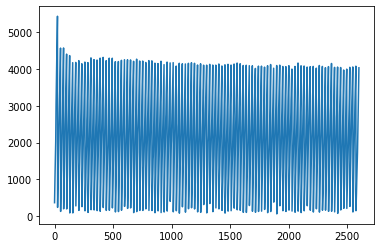

In [149]:
plt.plot(loss_trend)

In [191]:
nlp.pipe_names


['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [184]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [151]:
test_docs = train_reviews[900:920]

for doc in test_docs:
  displacy.render(nlp(doc),'ent',jupyter=True)

In [0]:
pwd

'/gdrive/My Drive/abv_reviews'

In [108]:
check_list

[('bok', 'U_vegetable'),
 ('choy', 'U_vegetable'),
 ('bean', 'U_vegetable'),
 ('sprouts', 'U_vegetable'),
 ('soffritto', 'U_dish'),
 ('patties', 'U_dish'),
 ('cakes', 'U_dish'),
 ('parmesan', 'U_dish'),
 ('cheese', 'U_dish'),
 ('breadcrumbs', 'U_dish'),
 ('soy', 'U_condiment'),
 ('sauce', 'U_condiment'),
 ('olive', 'U_condiment'),
 ('oil', 'U_condiment'),
 ('wine', 'U_beverage'),
 ('3/4-inch', 'U_QUANTITY'),
 ('2-inch', 'U_QUANTITY'),
 ('3-inch', 'U_QUANTITY'),
 ('6-inch', 'U_QUANTITY'),
 ('first', 'U_ORDINAL'),
 ('second', 'U_ORDINAL'),
 ('third', 'U_ORDINAL'),
 ('fourth', 'U_ORDINAL'),
 ('fifth', 'U_ORDINAL'),
 ('last', 'U_ORDINAL'),
 ('1', 'U_CARDINAL'),
 ('2', 'U_CARDINAL'),
 ('3', 'U_CARDINAL'),
 ('4', 'U_CARDINAL'),
 ('5', 'U_CARDINAL'),
 ('6', 'U_CARDINAL'),
 ('10', 'U_CARDINAL'),
 ('100', 'U_CARDINAL'),
 ('one', 'U_CARDINAL'),
 ('two', 'U_CARDINAL'),
 ('three', 'U_CARDINAL'),
 ('four', 'U_CARDINAL'),
 ('five', 'U_CARDINAL'),
 ('six', 'U_CARDINAL'),
 ('seven', 'U_CARDINAL'),
 ('

In [0]:
nlp.to_disk('trained_model_2020_01_08')

In [0]:
import json

with open('checklist.txt', 'w') as f:
    f.write(json.dumps(check_list))

In [114]:
[token.pos_ for token in nlp("lion's mane mushroom falafels")]

['NOUN', 'PART', 'NOUN', 'NOUN', 'NOUN']

In [0]:
for doc in list(nlp.pipe(texts[check])):
  displacy.render(doc,'ent',jupyter=True)
#  displacy.render(doc,'dep',jupyter=True,options={'distance': 60, 'fine_grained': True})